# GridWorld from homework01 & 02

In [11]:
import numpy as np

# inspired by: https://github.com/MJeremy2017/reinforcement-learning-implementation/blob/master/GridWorld/gridWorld.py
BOARD_ROWS = 3
BOARD_COLS = 5
# states = 3x5
WIN_STATE = (0, 2)
LOSE_STATE_I = (1, 0)
LOSE_STATE_II = (1, 4)
START = (2, 2)
WALL = (1, 2)
DETERMINISTIC = True

class GridWorld(): 
    def __init__(self, state=START):
        # Initialize GridWorld board
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])

        self.state = state
        self.det = DETERMINISTIC
        
    def giveReward(self):
        if self.state == WIN_STATE:
            return 1
        elif (self.state == LOSE_STATE_I) or (self.state == LOSE_STATE_II):
            return -1
        else:
            return 0

    def nextPosition(self, action):
        """
        action: up, down, left, right
        return: next position
        """
        if self.det:
            if action == 0:
                nextState = (self.state[0] - 1, self.state[1])
            elif action == 1:
                nextState = (self.state[0] + 1, self.state[1])
            elif action == 2:
                nextState = (self.state[0], self.state[1] - 1)
            else: 
                nextState = (self.state[0], self.state[1] + 1)
            # if next state legal aka. if field is free
            if (nextState[0] >= 0) and (nextState[0] <= (BOARD_ROWS -1)):  
                if (nextState[1] >= 0) and (nextState[1] <= (BOARD_COLS -1)):
                    if nextState != WALL:
                        return nextState
            return self.state

    def showBoard(self):
        """Show the GridWorld playfield in ASCII art"""
        self.board[self.state] = 1
        # Wall / barrier
        self.board[WALL] = -1
        # Win / Lose states
        self.board[WIN_STATE] = 2
        self.board[LOSE_STATE_I] = -2
        self.board[LOSE_STATE_II] = -2
        for i in range(0, BOARD_ROWS):
            print('-----------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                # Player
                if self.board[i, j] == 1:
                    token = '*'
                # Wall / barrier
                if self.board[i, j] == -1:
                    token = 'z'
                # Free fields
                if self.board[i, j] == 0:
                    token = '0'
                # Win state
                if self.board[i, j] == 2:
                    token = 'W'
                # Lose state
                if self.board[i, j] == -2:
                    token = 'L'
                out += token + ' | '
            print(out)
        print('-----------------')

GW = GridWorld()

# 2 Learning a policy via 1-step SARSA

In [12]:
class Agent():
    def __init__(self):
        self.GW = GridWorld()
        self.end = False

        # Initialize epsilon and epsilon-decay
        self.epsilon = 1
        self.decay = 0.999

        # Initialize dictionary to safe returns
        self.returns = {}
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                for k in range(4):
                    self.returns[(i, j), k] = [0,0] 

        # Initialize q-value table
        self.q_values = np.random.uniform(size=(3,5,4))
        # TERMINAL STATE = 0 ???
        #self.q_values[START,:] = 0
    
    def policy(self, epsilon, state):
        # Epsilon-greedy policy to coose action
        if np.random.rand() > epsilon:
          action = np.argmax(self.q_values[state])
        else:
          action = np.random.randint(0,4)
        return action

    def makeAct(self, action):      
        # Make action
        state = self.GW.nextPosition(action)
        self.GW.state = state

        reward = self.GW.giveReward()
        if reward==1 or reward==-1:
            # End game
            self.end = True
        return state, reward
    
    def reset(self):
        self.GW = GridWorld()
        self.end = False

    def play(self, alpha, gamma):
        i = 0

        # Safe state and action
        state = self.GW.state
        action = self.policy(self.epsilon, state)

        while self.end==False:
            # Take action to get next state and reward
            next_state, self.reward = self.makeAct(action)
            # Get next action via policy
            next_action = self.policy(self.epsilon, next_state)

            # Update q-values with 1-step SARSA
            self.q_values[state[0],state[1],action] = self.q_values[state[0],state[1],action] + alpha*(self.reward + 
                                                                                                       gamma*self.q_values[next_state[0],next_state[1],next_action] -
                                                                                                       self.q_values[state[0],state[1],action])

            state = next_state
            action = next_action
            
            # Decay epsilon after every turn
            self.epsilon *= self.decay

            i += 1
            # safety mechanism to prevent endless loop
            if i > 100:
                self.reward = -1
                break

        self.reset()

    # NEEDS TO BE REWORKED FOR OUTSTANDING
    def showValues(self):
        """Show MC-estimates per state aka. field in GridWorld"""
        for i in range(0, BOARD_ROWS):
            print('----------------------------------------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                out += str(self.erg[(i, j)]).ljust(6) + ' | '
            print(out)
        print('----------------------------------------------')

In [13]:
import time
ag = Agent()
GW.showBoard()

# Returns per episode
results = []
# Avg. returns per episode
rpe = []
# wallclock
times = []
start_time = time.time()

episodes = 10000

for k in range(episodes):
    ag.play(alpha=0.2, gamma=0.99)
    results.append(ag.reward)
    rpe.append(np.mean(results))
    times.append(time.time()-start_time)


-----------------
| 0 | 0 | W | 0 | 0 | 
-----------------
| L | 0 | z | 0 | L | 
-----------------
| 0 | 0 | * | 0 | 0 | 
-----------------


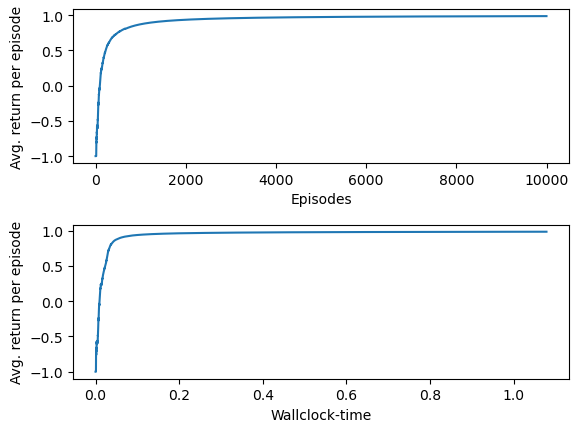

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(2,1,1)
plt.plot(np.arange(episodes), rpe);
plt.xlabel('Episodes');
plt.ylabel('Avg. return per episode');
plt.subplot(2,1,2)
plt.plot(times, rpe);
plt.xlabel('Wallclock-time');
plt.ylabel('Avg. return per episode');
plt.subplots_adjust(hspace=0.4)